<a href="https://colab.research.google.com/github/naimish75/Face-Detection-TFOD/blob/main/Quora_duplicate_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [2]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done


Restart Runtime

In [3]:
!pip install tf-models-official

In [4]:
import os
os.chdir("models/official/nlp/bert")
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from tokenization import FullTokenizer
from official.nlp import optimization

In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("Numpy version: ", np.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.15.0
Numpy version:  1.26.2
GPU is NOT AVAILABLE


In [6]:
# !pip install numpy


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/Quora_duplicate_Ans_BERT/archive.zip', compression = 'zip', low_memory=False)

df.shape

(100000, 8)

In [8]:
df.tail(20)

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate
99980,99980,313094,313094,437636,328403,What is it like to be the Pope's personal secu...,"Does the current Pope, Francis, have a food ta...",0
99981,99981,147229,147229,20243,8743,What are some of your favorite documentaries?,What are your favourite documentaries? Why?,1
99982,99982,341091,341091,468873,60713,How does a boat float?,Why does a boat float on water?,1
99983,99983,349940,349940,123825,478659,How can a stone float on water?,Why some stones float on water?,1
99984,99984,280835,280835,400491,400492,What are some good ways for breaking in a new ...,Why is the baseball home plate shaped the way ...,0
99985,99985,161688,161688,251876,251877,Discount rate inflation rate?,What is the best advice for the newly rich?,0
99986,99986,243511,243511,355963,355964,Will Rahul Gandhi be able to handle the Indian...,Will Rahul Gandhi be able to revive the Congre...,1
99987,99987,64670,64670,112339,112340,If you were guaranteed three honest answers to...,If you could have answers to any three questio...,1
99988,99988,134515,134515,214973,214974,What are potato bugs and are they harmful to h...,How harmful could it be to have bugs in the re...,0
99989,99989,199728,199728,186062,130104,What are some mind blowing Hover tools that mo...,What are some mind-blowing gadgets tools that ...,0


<Axes: title={'center': 'is_duplicate'}, ylabel='Frequency'>

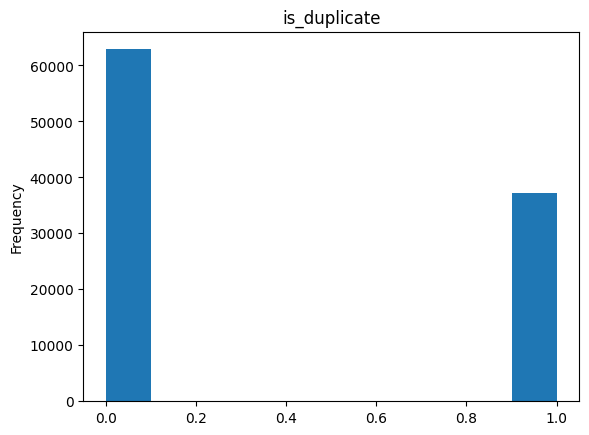

In [9]:
df.is_duplicate.plot(kind = 'hist',title = 'is_duplicate')

In [10]:
train_df, remaining = train_test_split(df, random_state=42, train_size = 0.0075, stratify=df.is_duplicate.values)
valid_df, _= train_test_split(remaining, random_state = 42, train_size=0.00075, stratify = remaining.is_duplicate.values)
train_df.shape, valid_df.shape

((750, 8), (74, 8))

In [11]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question1'].values, train_df['is_duplicate'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question1.values, valid_df.is_duplicate.values))

  for text, label in train_data.take(1):
    print(text)
    #print(text2)
    print(label)

tf.Tensor(b'How do you find jobs in Canada from United Kingdom?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [12]:
from google.protobuf.text_format import Tokenizer


label_list = [0,1]
max_seq_length = 128
train_batch_size = 32
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file,do_lower_case)

In [13]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [14]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                              text_a = text.numpy(),
                                              text_b = None,
                                              label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return(feature.input_ids, feature.input_mask,feature.segment_ids, feature.label_id)

In [23]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label],
                                                               Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id.set_shape([])

  x = {
      'input_word_ids':input_ids,
       'input_mask':input_mask,
       'input_type_ids':segment_ids
  }

  return(x, label_id)

In [24]:
with tf.device('/cpu:0'):

  train_data = (train_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))


In [25]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.3)(pooled_output)
  output = tf.keras.layers.Dense(1,activation = 'sigmoid', name = 'output')(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids':input_word_ids,
          'input_mask':input_mask,
          'input_type_ids': input_type_ids
      },

      outputs = output
  )
  return model

In [26]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
num_epochs = 10
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = num_epochs,
                    verbose = 1)

Epoch 1/10
 5/23 [=====>........................] - ETA: 14:03 - loss: 5.4350 - binary_accuracy: 0.5125

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'binary_accuracy')